<h1> HW3 </h1>

## Q1.a

In [48]:
import numpy as np
import pandas as pd
import os
import tensorflow as T
import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, merge, Reshape, Merge, Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adamax
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from time import time
import multiprocessing as mp
import sys
import math
import argparse
import matplotlib.pyplot as plt

Define dataset folder and files

In [32]:
MOVIELENS_DIR = 'ml-100k/'
RATING_DATA_FILE = 'u1.base'
RATINGS_CSV_FILE = 'u1_emb.data'
MODEL_WEIGHTS_FILE = 'u1_emb_weights.h5'

The user and item id for embedding should start from 0.
Update ids and save to file

In [33]:
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='\t', 
                    engine='python', 
                    encoding='latin-1',
                    names=['userid', 'movieid', 'rating', 'timestamp'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
ratings['user_emb_id'] = ratings['userid'] - 1
ratings['movie_emb_id'] = ratings['movieid'] - 1
print(str(len(ratings))+' ratings loaded')
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['userid', 'movieid', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])
print('Saved to '+RATINGS_CSV_FILE)

80000 ratings loaded
Saved to u1_emb.data


Load train rating file

In [34]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'])
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print(str(len(ratings)), 'ratings loaded.')
print('users '+str(max_userid)+' items '+str(max_movieid))

80000 ratings loaded.
users 943 items 1682


In [35]:
print(ratings)

       userid  movieid  rating  user_emb_id  movie_emb_id
0           1        1       5            0             0
1           1        2       3            0             1
2           1        3       4            0             2
3           1        4       3            0             3
4           1        5       3            0             4
5           1        7       4            0             6
6           1        8       1            0             7
7           1        9       5            0             8
8           1       11       2            0            10
9           1       13       5            0            12
10          1       15       5            0            14
11          1       16       5            0            15
12          1       18       4            0            17
13          1       19       5            0            18
14          1       21       1            0            20
15          1       22       4            0            21
16          1 

Prepare inputs to model

In [36]:
shuffled_ratings = ratings.sample(frac=1.)
Users = shuffled_ratings['user_emb_id'].values
Movies = shuffled_ratings['movie_emb_id'].values
Ratings = shuffled_ratings['rating'].values

In [37]:
shuffled_ratings

,userid,movieid,rating,user_emb_id,movie_emb_id
65705,804,97,4,803,96
29050,435,264,3,434,263
221,5,63,1,4,62
45730,592,988,1,591,987
19032,325,186,4,324,185
41612,545,202,4,544,201
48574,625,183,3,624,182
39053,526,748,1,525,747
49453,635,1,4,634,0
70569,854,1011,2,853,1010


Define matrix factorization model

In [38]:
def get_model(num_users, num_items, latent_dim):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    prediction = merge([user_latent, item_latent], mode = 'dot')
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model


Define embedding size and compile model

In [39]:
K_LATENT = 20
MF_model = get_model(max_userid,max_movieid,K_LATENT)
MF_model.compile(loss='mse', optimizer='adamax',metrics=['mae'])

C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("me...)`


## Q1.b

Train model

In [54]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyMF = MF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 6s 96us/step - loss: 1.3070 - mean_absolute_error: 0.8721 - val_loss: 1.3661 - val_mean_absolute_error: 0.8910
Epoch 2/12
64000/64000 [==============================] - 7s 103us/step - loss: 1.2321 - mean_absolute_error: 0.8478 - val_loss: 1.2977 - val_mean_absolute_error: 0.8694
Epoch 3/12
64000/64000 [==============================] - 7s 107us/step - loss: 1.1744 - mean_absolute_error: 0.8287 - val_loss: 1.2418 - val_mean_absolute_error: 0.8515
Epoch 4/12
64000/64000 [==============================] - 6s 101us/step - loss: 1.1280 - mean_absolute_error: 0.8134 - val_loss: 1.1982 - val_mean_absolute_error: 0.8375
Epoch 5/12
64000/64000 [==============================] - 6s 97us/step - loss: 1.0908 - mean_absolute_error: 0.8011 - val_loss: 1.1622 - val_mean_absolute_error: 0.8265
Epoch 6/12
64000/64000 [==============================] - 6s 98us/step - loss: 1.0601 - mean_absolute_

In [55]:
def printSumMSE(history):
    loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                         'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                         'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})

    plt.plot(loss['training'])
    plt.plot(loss['validation'])
    plt.title('model rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

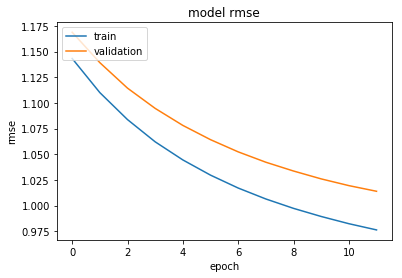

In [56]:
printSumMSE(historyMF)

## Q1.c

In HW2 we got MAE 0.5956766082578648, in one epoc.
in HW3 we got MAE 0.9030 in 12 epoches
We can understand from above that our pediction model worked better, because we based on non-personal recomandations.



## Q2.a

In [57]:
def get_ncf_model(num_users, num_items, latent_dim,hidden_dim,do):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    conc = Concatenate()([user_latent, item_latent])
    drop = Dropout(0.5)(conc)
    hid1 = Dense(hidden_dim, activation='relu')(conc)
    drop2  = Dropout(do)(hid1)
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = 'prediction')(drop2)
    
    
    model = Model(input=[user_input, item_input], output=prediction)

    return model

In [58]:
K_LATENT = 20
hidden_dim = 1
do = 0.5

NCF_model = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


## Q2.b

In [59]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF = NCF_model.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 8s 119us/step - loss: 4.4250 - mean_absolute_error: 1.7113 - val_loss: 1.2929 - val_mean_absolute_error: 0.9376
Epoch 2/12
64000/64000 [==============================] - 6s 100us/step - loss: 1.2541 - mean_absolute_error: 0.9110 - val_loss: 1.1205 - val_mean_absolute_error: 0.8780
Epoch 3/12
64000/64000 [==============================] - 6s 88us/step - loss: 1.1569 - mean_absolute_error: 0.8827 - val_loss: 1.1118 - val_mean_absolute_error: 0.8725
Epoch 4/12
64000/64000 [==============================] - 5s 84us/step - loss: 1.1537 - mean_absolute_error: 0.8804 - val_loss: 1.1080 - val_mean_absolute_error: 0.8695
Epoch 5/12
64000/64000 [==============================] - 5s 77us/step - loss: 1.1449 - mean_absolute_error: 0.8764 - val_loss: 1.1075 - val_mean_absolute_error: 0.8706
Epoch 6/12
64000/64000 [==============================] - 5s 84us/step - loss: 1.1433 - mean_absolute_e

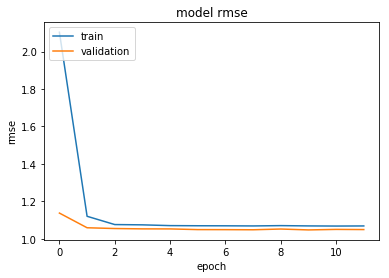

In [60]:
printSumMSE(historyNCF)

## in 1 hidden layer we got mean_absolute_error: 0.8654

## now we try difrrent Option with 10 hidden layer

In [61]:
K_LATENT = 20
hidden_dim = 10
do = 0.5

NCF_model2 = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model2.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [62]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF2 = NCF_model2.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 8s 129us/step - loss: 3.0027 - mean_absolute_error: 1.3783 - val_loss: 1.0563 - val_mean_absolute_error: 0.8450
Epoch 2/12
64000/64000 [==============================] - 7s 113us/step - loss: 1.3393 - mean_absolute_error: 0.9326 - val_loss: 0.9630 - val_mean_absolute_error: 0.7981
Epoch 3/12
64000/64000 [==============================] - 7s 112us/step - loss: 1.0315 - mean_absolute_error: 0.8155 - val_loss: 0.9245 - val_mean_absolute_error: 0.7712
Epoch 4/12
64000/64000 [==============================] - 7s 105us/step - loss: 0.9560 - mean_absolute_error: 0.7817 - val_loss: 0.9068 - val_mean_absolute_error: 0.7574
Epoch 5/12
64000/64000 [==============================] - 7s 114us/step - loss: 0.9256 - mean_absolute_error: 0.7678 - val_loss: 0.9000 - val_mean_absolute_error: 0.7548
Epoch 6/12
64000/64000 [==============================] - 7s 108us/step - loss: 0.9163 - mean_absolu

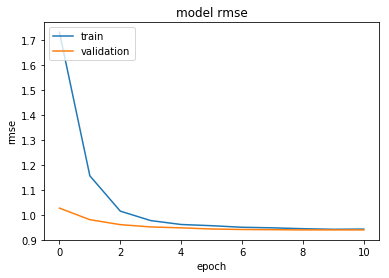

In [64]:
printSumMSE(historyNCF2)

## We got mean_absolute_error: 0.7487

## now we try with 5 hidden layer, and K_LATENT = 10

In [63]:
K_LATENT = 10
hidden_dim = 5
do = 0.5

NCF_model3 = get_ncf_model(max_userid,max_movieid,K_LATENT,hidden_dim,do)
NCF_model3.compile(loss='mse',optimizer=Adamax(),metrics=['mae'])

C:\Users\qvkg67\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pr...)`


In [65]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
historyNCF3 = NCF_model3.fit([Users, Movies], Ratings, epochs=12, validation_split=.2, verbose=1, callbacks=callbacks)

Train on 64000 samples, validate on 16000 samples
Epoch 1/12
64000/64000 [==============================] - 8s 126us/step - loss: 4.4967 - mean_absolute_error: 1.7292 - val_loss: 1.3377 - val_mean_absolute_error: 0.9516
Epoch 2/12
64000/64000 [==============================] - 7s 106us/step - loss: 1.2568 - mean_absolute_error: 0.9092 - val_loss: 1.0244 - val_mean_absolute_error: 0.8292
Epoch 3/12
64000/64000 [==============================] - 6s 96us/step - loss: 1.0501 - mean_absolute_error: 0.8308 - val_loss: 0.9764 - val_mean_absolute_error: 0.7986
Epoch 4/12
64000/64000 [==============================] - 5s 78us/step - loss: 1.0241 - mean_absolute_error: 0.8164 - val_loss: 0.9552 - val_mean_absolute_error: 0.7873
Epoch 5/12
64000/64000 [==============================] - 5s 81us/step - loss: 1.0059 - mean_absolute_error: 0.8075 - val_loss: 0.9444 - val_mean_absolute_error: 0.7839
Epoch 6/12
64000/64000 [==============================] - 5s 82us/step - loss: 1.0063 - mean_absolute_e

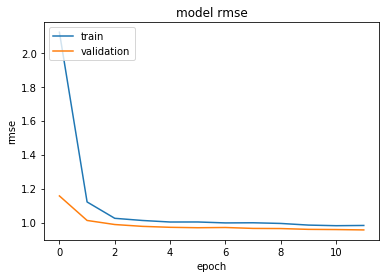

In [66]:
printSumMSE(historyNCF3)

## We got mean_absolute_error: 0.7639


## Q2.c

## We can see that in the first option get MAE 0.8654
## The second option MAE 0.7487
## The third optione MAE 0.7639

# So the best is the third option! with 5 hidden layer, and K_LATENT = 10

## Q3.1